In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from datetime import datetime
import torch
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve
from sklearn.inspection import permutation_importance

In [2]:
# Import PyTorch TabNet implementation
try:
    from pytorch_tabnet.tab_model import TabNetClassifier
    TABNET_AVAILABLE = True
except ImportError:
    TABNET_AVAILABLE = False
    print("Warning: pytorch_tabnet is not installed. Please install it with:")
    print("pip install pytorch-tabnet")
    print("Exiting script.")
    import sys
    sys.exit(1)

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [10]:
# Path to your processed wildfire-weather dataset
input_file = os.path.abspath("../data/wildfire_weather_interpolated_merged_cleaned.csv")

# Output directory for model artifacts
output_dir = os.path.abspath("../models/tabnet/classification_2")

# Define classification threshold in hectares (same as XGBoost and SVM for comparison)
threshold = 0.01

In [11]:
target_column='FIRE_SIZE_HA'

In [12]:
# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
model_dir = os.path.join(output_dir, 'models')
os.makedirs(model_dir, exist_ok=True)

# Initialize results dictionary
results = {}

print("="*80)
print(f"WILDFIRE CLASSIFICATION TABNET MODEL TRAINING (Threshold: {threshold} ha)")
print("="*80)

# 1. LOAD AND PREPARE DATA
print("\n1. LOADING AND PREPARING DATA")
print("-"*50)

# Load the dataset
print(f"Loading data from {input_file}")
df = pd.read_csv(input_file)

# Convert date to datetime
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    # Extract additional temporal features if not already present
    if 'Year' not in df.columns:
        df['Year'] = df['Date'].dt.year
    if 'Month' not in df.columns:
        df['Month'] = df['Date'].dt.month
    if 'DayOfYear' not in df.columns:
        df['DayOfYear'] = df['Date'].dt.dayofyear

# Check if target column exists
if target_column not in df.columns:
    raise ValueError(f"Target column '{target_column}' not found in the dataset")

# Create binary classification target based on threshold
binary_target = f"{target_column}_binary"
df[binary_target] = (df[target_column] >= threshold).astype(int)

# Calculate class distribution
class_counts = df[binary_target].value_counts()
class_percentages = class_counts / len(df) * 100

print(f"Created binary target '{binary_target}' with threshold {threshold} hectares")
print(f"Class distribution:")
print(f"  Class 0 (< {threshold} ha): {class_counts[0]} samples ({class_percentages[0]:.2f}%)")
print(f"  Class 1 (>= {threshold} ha): {class_counts[1]} samples ({class_percentages[1]:.2f}%)")

# If classes are very imbalanced, log a warning
if min(class_percentages) < 10:
    print(f"WARNING: Classes are imbalanced. Consider using class weights or resampling techniques.")

WILDFIRE CLASSIFICATION TABNET MODEL TRAINING (Threshold: 0.01 ha)

1. LOADING AND PREPARING DATA
--------------------------------------------------
Loading data from /Users/rchang/ML-Projects/wildfire-prediction-can/data/wildfire_weather_interpolated_merged_cleaned.csv
Created binary target 'FIRE_SIZE_HA_binary' with threshold 0.01 hectares
Class distribution:
  Class 0 (< 0.01 ha): 599 samples (41.45%)
  Class 1 (>= 0.01 ha): 846 samples (58.55%)


In [13]:
# 2. FEATURE ENGINEERING AND SELECTION
print("\n2. FEATURE ENGINEERING AND SELECTION")
print("-"*50)

# Drop non-feature columns
exclude_cols = ['Date']

# Identify numeric columns (potential features)
feature_cols = df.select_dtypes(include=['number']).columns.tolist()
feature_cols = [col for col in feature_cols if col not in exclude_cols and 
                col != target_column and col != binary_target]

print(f"Initial feature count: {len(feature_cols)}")

# Handle missing values in features if any
for col in feature_cols:
    if df[col].isnull().sum() > 0:
        print(f"Warning: Column {col} has {df[col].isnull().sum()} missing values.")

# Check for constant or near-constant features
near_constant_threshold = 0.99
near_constant_features = []

for col in feature_cols:
    # Calculate the percentage of the most common value
    most_common_pct = df[col].value_counts(normalize=True).max()
    if most_common_pct > near_constant_threshold:
        near_constant_features.append(col)

if near_constant_features:
    print(f"Removing {len(near_constant_features)} near-constant features:")
    for col in near_constant_features:
        print(f"  - {col}: {df[col].value_counts(normalize=True).max():.2%} most common value")
    
    # Remove these features
    feature_cols = [col for col in feature_cols if col not in near_constant_features]

print(f"Features after removing near-constants: {len(feature_cols)}")

# Save feature list for later use
with open(os.path.join(output_dir, 'feature_columns.txt'), 'w') as f:
    f.write('\n'.join(feature_cols))


2. FEATURE ENGINEERING AND SELECTION
--------------------------------------------------
Initial feature count: 85
Removing 1 near-constant features:
  - ONE_DAY_SNOW: 99.10% most common value
Features after removing near-constants: 84


In [14]:
# 3. DATA SPLITTING
print("\n3. SPLITTING DATA INTO TRAIN/VALIDATION/TEST SETS")
print("-"*50)

# Get features and target
X = df[feature_cols].values
y = df[binary_target].values

# First split: 80% train+validation, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

# Second split: 75% train, 25% validation (resulting in 60%/20%/20% split overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=RANDOM_SEED, stratify=y_train_val
)

print(f"Training set size: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Verify class distribution in the splits
print("Class distribution in splits:")
print(f"  Training set: {np.bincount(y_train) / len(y_train) * 100}")
print(f"  Validation set: {np.bincount(y_val) / len(y_val) * 100}")
print(f"  Test set: {np.bincount(y_test) / len(y_test) * 100}")


3. SPLITTING DATA INTO TRAIN/VALIDATION/TEST SETS
--------------------------------------------------
Training set size: 867 samples, 84 features
Validation set size: 289 samples
Test set size: 289 samples
Class distribution in splits:
  Training set: [41.4071511 58.5928489]
  Validation set: [41.52249135 58.47750865]
  Test set: [41.52249135 58.47750865]


In [15]:
# 4. FEATURE SCALING
print("\n4. FEATURE SCALING")
print("-"*50)

# TabNet generally performs better with normalized features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


4. FEATURE SCALING
--------------------------------------------------



5. DEFINING BASELINE TABNET MODEL
--------------------------------------------------
Training baseline TabNet model...

Early stopping occurred at epoch 33 with best_epoch = 18 and best_val_0_logloss = 0.53836
Baseline model training accuracy: 0.7197
Baseline model validation accuracy: 0.6782
Baseline model training F1: 0.7373
Baseline model validation F1: 0.6931
Baseline model training AUC: 0.8070
Baseline model validation AUC: 0.7480
Baseline metrics saved to /Users/rchang/ML-Projects/wildfire-prediction-can/models/tabnet/classification_2/baseline_model_metrics.csv
Baseline metrics text summary saved to /Users/rchang/ML-Projects/wildfire-prediction-can/models/tabnet/classification_2/baseline_model_metrics.txt
Feature importance saved to /Users/rchang/ML-Projects/wildfire-prediction-can/models/tabnet/classification_2/baseline_feature_importance.csv


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


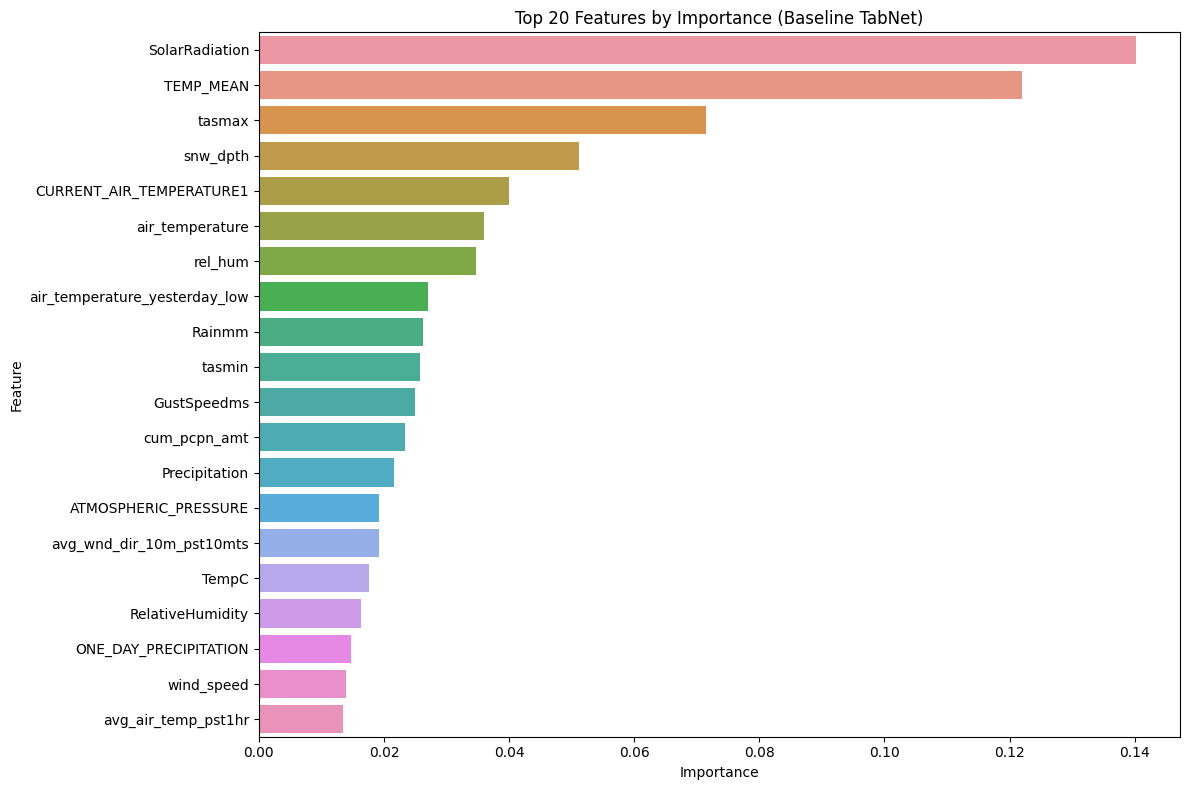

In [16]:
# 5. DEFINE TABNET BASELINE MODEL
print("\n5. DEFINING BASELINE TABNET MODEL")
print("-"*50)

# Calculate class weight if needed
if min(class_percentages) < 20:
    # Compute weights based on class frequencies
    class_weights = len(y_train) / (2 * np.bincount(y_train))
    print(f"Using class weights due to imbalance: {class_weights}")
else:
    class_weights = None

# Initialize TabNet with baseline parameters
baseline_model = TabNetClassifier(
    n_d=16,  # Width of the decision prediction layer
    n_a=16,  # Width of the attention embedding for each step
    n_steps=3,  # Number of steps in the architecture
    gamma=1.5,  # Scaling factor for attention
    lambda_sparse=1e-3,  # Strength of the sparsity regularization
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params=dict(
        mode="min", patience=5, min_lr=1e-5, factor=0.5
    ),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    mask_type='entmax',  # "entmax" or "sparsemax"
    verbose=0,
    seed=RANDOM_SEED
)

# Train the baseline model
print("Training baseline TabNet model...")

# Set class weights if needed
baseline_model.class_weight = class_weights

# Fit the model - TabNet's fit method works similar to sklearn
baseline_model.fit(
    X_train=X_train_scaled, y_train=y_train,
    eval_set=[(X_val_scaled, y_val)],
    eval_metric=['accuracy', 'logloss'],
    max_epochs=50,
    patience=15,
    batch_size=256
)

# Get baseline predictions
y_train_pred = baseline_model.predict(X_train_scaled)
y_val_pred = baseline_model.predict(X_val_scaled)

# Get probability predictions
y_train_pred_proba = baseline_model.predict_proba(X_train_scaled)[:,1]
y_val_pred_proba = baseline_model.predict_proba(X_val_scaled)[:,1]

# Calculate baseline metrics
baseline_train_accuracy = accuracy_score(y_train, y_train_pred)
baseline_val_accuracy = accuracy_score(y_val, y_val_pred)
baseline_train_f1 = f1_score(y_train, y_train_pred)
baseline_val_f1 = f1_score(y_val, y_val_pred)
baseline_train_auc = roc_auc_score(y_train, y_train_pred_proba)
baseline_val_auc = roc_auc_score(y_val, y_val_pred_proba)

print(f"Baseline model training accuracy: {baseline_train_accuracy:.4f}")
print(f"Baseline model validation accuracy: {baseline_val_accuracy:.4f}")
print(f"Baseline model training F1: {baseline_train_f1:.4f}")
print(f"Baseline model validation F1: {baseline_val_f1:.4f}")
print(f"Baseline model training AUC: {baseline_train_auc:.4f}")
print(f"Baseline model validation AUC: {baseline_val_auc:.4f}")

# Write baseline metrics to file
baseline_metrics = {
    'baseline_train_accuracy': baseline_train_accuracy,
    'baseline_val_accuracy': baseline_val_accuracy,
    'baseline_train_f1': baseline_train_f1,
    'baseline_val_f1': baseline_val_f1,
    'baseline_train_auc': baseline_train_auc,
    'baseline_val_auc': baseline_val_auc
}

# Create metrics dataframe and save to CSV
baseline_metrics_df = pd.DataFrame([baseline_metrics])
baseline_metrics_df.to_csv(os.path.join(output_dir, 'baseline_model_metrics.csv'), index=False)
print(f"Baseline metrics saved to {os.path.join(output_dir, 'baseline_model_metrics.csv')}")

# Also write a more readable text version
with open(os.path.join(output_dir, 'baseline_model_metrics.txt'), 'w') as f:
    f.write("BASELINE TABNET MODEL METRICS\n")
    f.write("=" * 30 + "\n\n")
    f.write("Default Parameters:\n")
    f.write(f"  n_d: 16\n")
    f.write(f"  n_a: 16\n")
    f.write(f"  n_steps: 3\n")
    f.write(f"  gamma: 1.5\n")
    f.write(f"  lambda_sparse: 1e-3\n")
    f.write(f"  batch_size: 256\n")
    f.write(f"  max_epochs: 50\n")
    f.write(f"  patience: 15\n")
    f.write(f"  class_weight: {class_weights}\n\n")
    f.write(f"Training Accuracy: {baseline_train_accuracy:.4f}\n")
    f.write(f"Validation Accuracy: {baseline_val_accuracy:.4f}\n\n")
    f.write(f"Training F1 Score: {baseline_train_f1:.4f}\n")
    f.write(f"Validation F1 Score: {baseline_val_f1:.4f}\n\n")
    f.write(f"Training AUC: {baseline_train_auc:.4f}\n")
    f.write(f"Validation AUC: {baseline_val_auc:.4f}\n")
print(f"Baseline metrics text summary saved to {os.path.join(output_dir, 'baseline_model_metrics.txt')}")

# Get the feature importance scores
feature_importance = baseline_model.feature_importances_

# Create DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Save feature importance to CSV
feature_importance_df.to_csv(os.path.join(output_dir, 'baseline_feature_importance.csv'), index=False)
print(f"Feature importance saved to {os.path.join(output_dir, 'baseline_feature_importance.csv')}")

# Plot feature importance (top 20)
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20)
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 20 Features by Importance (Baseline TabNet)')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'baseline_feature_importance.png'))


In [17]:
# 6. HYPERPARAMETER TUNING
print("\n6. HYPERPARAMETER TUNING")
print("-"*50)

# Define parameter grid (smaller than usual due to TabNet's training time)
param_grid = [
    {
        'n_d': [8, 16, 32],
        'n_a': [8, 16, 32],
        'n_steps': [3, 5],
        'gamma': [1.0, 1.5],
        'lambda_sparse': [1e-4, 1e-3, 1e-2],
        'batch_size': [256, 512]
    }
]

best_val_f1 = 0
best_params = None
best_model = None

print("Starting hyperparameter search...")

# Create a simpler grid for smaller datasets
if X_train_scaled.shape[0] < 500:
    print("Small dataset detected. Using reduced parameter grid.")
    param_grid = [
        {
            'n_d': [8, 16],
            'n_a': [8, 16],
            'n_steps': [3],
            'gamma': [1.5],
            'lambda_sparse': [1e-3, 1e-2],
            'batch_size': [256]
        }
    ]

# Create fold indices for cross-validation
cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
fold_indices = list(cv.split(X_train_scaled))

# Manual grid search with cross-validation
for param_set in param_grid:
    # Create all parameter combinations
    param_keys = list(param_set.keys())
    param_values = list(param_set.values())
    
    # Get all parameter combinations
    import itertools
    param_combinations = list(itertools.product(*param_values))
    
    for params in param_combinations:
        param_dict = {param_keys[i]: params[i] for i in range(len(param_keys))}
        
        # Display current parameter set
        print(f"\nTrying parameters: {param_dict}")
        
        # Extract batch size for training
        batch_size = param_dict.pop('batch_size')
        
        # Cross-validation loop
        cv_scores = []
        for fold_idx, (train_idx, val_idx) in enumerate(fold_indices):
            # Prepare fold data
            X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
            y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
            
            # Initialize TabNet with current parameters
            tabnet_fold = TabNetClassifier(
                **param_dict,
                optimizer_fn=torch.optim.Adam,
                optimizer_params=dict(lr=2e-2),
                scheduler_params=dict(
                    mode="min", patience=5, min_lr=1e-5, factor=0.5
                ),
                scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                mask_type='entmax',
                verbose=0,
                seed=RANDOM_SEED
            )
            
            # Set class weights if needed
            tabnet_fold.class_weight = class_weights
            
            # Fit on this fold
            tabnet_fold.fit(
                X_train=X_fold_train, y_train=y_fold_train,
                eval_set=[(X_fold_val, y_fold_val)],
                eval_metric=['logloss'],
                max_epochs=30,  # Reduced for grid search
                patience=10,
                batch_size=batch_size
            )
            
            # Evaluate on validation fold
            y_fold_val_pred = tabnet_fold.predict(X_fold_val)
            fold_f1 = f1_score(y_fold_val, y_fold_val_pred)
            cv_scores.append(fold_f1)
            
            print(f"  Fold {fold_idx+1}/3: F1 = {fold_f1:.4f}")
        
        # Calculate average F1 across folds
        avg_f1 = np.mean(cv_scores)
        print(f"  Average CV F1: {avg_f1:.4f}")
        
        # Check if this is the best model so far
        if avg_f1 > best_val_f1:
            best_val_f1 = avg_f1
            param_dict['batch_size'] = batch_size  # Add batch_size back for final training
            best_params = param_dict


6. HYPERPARAMETER TUNING
--------------------------------------------------
Starting hyperparameter search...

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 256}

Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.62013
  Fold 1/3: F1 = 0.6531


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.63711
  Fold 2/3: F1 = 0.6391


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.62663
  Fold 3/3: F1 = 0.6705
  Average CV F1: 0.6542

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.62645
  Fold 1/3: F1 = 0.6856


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_logloss = 0.67356
  Fold 2/3: F1 = 0.6734


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.62097
  Fold 3/3: F1 = 0.6593
  Average CV F1: 0.6727

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_val_0_logloss = 0.62712
  Fold 1/3: F1 = 0.6454


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.59397
  Fold 2/3: F1 = 0.6748


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 22 and best_val_0_logloss = 0.6184
  Fold 3/3: F1 = 0.6756
  Average CV F1: 0.6652

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.59475
  Fold 1/3: F1 = 0.7130


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.64251
  Fold 2/3: F1 = 0.6316


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_logloss = 0.67495
  Fold 3/3: F1 = 0.6856
  Average CV F1: 0.6767

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 24 and best_val_0_logloss = 0.55743
  Fold 1/3: F1 = 0.7129


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 23 and best_val_0_logloss = 0.60826
  Fold 2/3: F1 = 0.6975


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.62493
  Fold 3/3: F1 = 0.6580
  Average CV F1: 0.6895

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.61342
  Fold 1/3: F1 = 0.6905


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_logloss = 0.67049
  Fold 2/3: F1 = 0.6919


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_logloss = 0.67516
  Fold 3/3: F1 = 0.6856
  Average CV F1: 0.6893

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.59275
  Fold 1/3: F1 = 0.7417


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.65913
  Fold 2/3: F1 = 0.5390


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 20 and best_val_0_logloss = 0.65471
  Fold 3/3: F1 = 0.5895
  Average CV F1: 0.6234

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.58577
  Fold 1/3: F1 = 0.6997


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_logloss = 0.65891
  Fold 2/3: F1 = 0.7013


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_logloss = 0.66683
  Fold 3/3: F1 = 0.7143
  Average CV F1: 0.7051

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.59174
  Fold 1/3: F1 = 0.7033


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.64942
  Fold 2/3: F1 = 0.6149


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.62067
  Fold 3/3: F1 = 0.6254
  Average CV F1: 0.6479

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_logloss = 0.66644
  Fold 1/3: F1 = 0.6650


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.65041
  Fold 2/3: F1 = 0.6604


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_logloss = 0.6632
  Fold 3/3: F1 = 0.7255
  Average CV F1: 0.6836

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 22 and best_val_0_logloss = 0.58299
  Fold 1/3: F1 = 0.7125


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.66542
  Fold 2/3: F1 = 0.5474


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.63728
  Fold 3/3: F1 = 0.6432
  Average CV F1: 0.6344

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.60441
  Fold 1/3: F1 = 0.6887


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.63008
  Fold 2/3: F1 = 0.6286


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_logloss = 0.66872
  Fold 3/3: F1 = 0.7050
  Average CV F1: 0.6741

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.57267
  Fold 1/3: F1 = 0.7212


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_logloss = 0.67413
  Fold 2/3: F1 = 0.7494


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.61706
  Fold 3/3: F1 = 0.5914
  Average CV F1: 0.6873

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.66156
  Fold 1/3: F1 = 0.7321


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_logloss = 0.65081
  Fold 2/3: F1 = 0.7522


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.63963
  Fold 3/3: F1 = 0.6540
  Average CV F1: 0.7128

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.56045
  Fold 1/3: F1 = 0.7309


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_logloss = 0.67055
  Fold 2/3: F1 = 0.7431


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_val_0_logloss = 0.61507
  Fold 3/3: F1 = 0.6486
  Average CV F1: 0.7075

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_logloss = 0.65586
  Fold 1/3: F1 = 0.7352


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_logloss = 0.65051
  Fold 2/3: F1 = 0.7522


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.63424
  Fold 3/3: F1 = 0.6467
  Average CV F1: 0.7114

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.53553
  Fold 1/3: F1 = 0.7492


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_logloss = 0.65728
  Fold 2/3: F1 = 0.7401


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.62173
  Fold 3/3: F1 = 0.6888
  Average CV F1: 0.7261

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.6561
  Fold 1/3: F1 = 0.7402


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_logloss = 0.65224
  Fold 2/3: F1 = 0.7589


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.62962
  Fold 3/3: F1 = 0.6790
  Average CV F1: 0.7261

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.62473
  Fold 1/3: F1 = 0.6925


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 20 and best_val_0_logloss = 0.64499
  Fold 2/3: F1 = 0.6059


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.61676
  Fold 3/3: F1 = 0.6975
  Average CV F1: 0.6653

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_logloss = 0.66802
  Fold 1/3: F1 = 0.6872


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.64165
  Fold 2/3: F1 = 0.6239


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.67191
  Fold 3/3: F1 = 0.7178
  Average CV F1: 0.6763

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 23 and best_val_0_logloss = 0.59223
  Fold 1/3: F1 = 0.7584


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 24 and best_val_0_logloss = 0.65294
  Fold 2/3: F1 = 0.5878


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.63916
  Fold 3/3: F1 = 0.6343
  Average CV F1: 0.6602

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_logloss = 0.67474
  Fold 1/3: F1 = 0.6842


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.65084
  Fold 2/3: F1 = 0.6409


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.65056
  Fold 3/3: F1 = 0.6857
  Average CV F1: 0.6703

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.59214
  Fold 1/3: F1 = 0.7168


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.63845
  Fold 2/3: F1 = 0.6646


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.64811
  Fold 3/3: F1 = 0.6025
  Average CV F1: 0.6613

Trying parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.62552
  Fold 1/3: F1 = 0.7170


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.65335
  Fold 2/3: F1 = 0.7354


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.62918
  Fold 3/3: F1 = 0.6857
  Average CV F1: 0.7127

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.60195
  Fold 1/3: F1 = 0.7135


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.63691
  Fold 2/3: F1 = 0.6490


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.63134
  Fold 3/3: F1 = 0.6839
  Average CV F1: 0.6821

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 23 and best_val_0_logloss = 0.59914
  Fold 1/3: F1 = 0.6989


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.64683
  Fold 2/3: F1 = 0.6880


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 23 and best_val_0_logloss = 0.61167
  Fold 3/3: F1 = 0.6977
  Average CV F1: 0.6949

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_logloss = 0.66042
  Fold 1/3: F1 = 0.6975


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.64575
  Fold 2/3: F1 = 0.6000


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.65432
  Fold 3/3: F1 = 0.6386
  Average CV F1: 0.6453

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 23 and best_val_0_logloss = 0.60085
  Fold 1/3: F1 = 0.6842


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.65955
  Fold 2/3: F1 = 0.6000


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.5968
  Fold 3/3: F1 = 0.6286
  Average CV F1: 0.6376

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.6272
  Fold 1/3: F1 = 0.7040


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_logloss = 0.6505
  Fold 2/3: F1 = 0.7336


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.66126
  Fold 3/3: F1 = 0.6302
  Average CV F1: 0.6893

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_val_0_logloss = 0.60494
  Fold 1/3: F1 = 0.7409


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.62128
  Fold 2/3: F1 = 0.6915


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.62161
  Fold 3/3: F1 = 0.6748
  Average CV F1: 0.7024

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.5864
  Fold 1/3: F1 = 0.7251


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.64124
  Fold 2/3: F1 = 0.6070


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_logloss = 0.66734
  Fold 3/3: F1 = 0.7026
  Average CV F1: 0.6783

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_val_0_logloss = 0.5976
  Fold 1/3: F1 = 0.7075


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_logloss = 0.67641
  Fold 2/3: F1 = 0.6351


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.66722
  Fold 3/3: F1 = 0.7227
  Average CV F1: 0.6884

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.55514
  Fold 1/3: F1 = 0.7168


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.63581
  Fold 2/3: F1 = 0.6222


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.63505
  Fold 3/3: F1 = 0.6096
  Average CV F1: 0.6495

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.54662
  Fold 1/3: F1 = 0.7354


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.65007
  Fold 2/3: F1 = 0.6586


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.65239
  Fold 3/3: F1 = 0.6901
  Average CV F1: 0.6947

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_logloss = 0.65814
  Fold 1/3: F1 = 0.7350


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.65418
  Fold 2/3: F1 = 0.6078


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.63857
  Fold 3/3: F1 = 0.6704
  Average CV F1: 0.6711

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.62863
  Fold 1/3: F1 = 0.7119


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.64621
  Fold 2/3: F1 = 0.5586


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 24 and best_val_0_logloss = 0.61943
  Fold 3/3: F1 = 0.6778
  Average CV F1: 0.6494

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.58414
  Fold 1/3: F1 = 0.7258


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.58769
  Fold 2/3: F1 = 0.7154


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 20 and best_val_0_logloss = 0.62056
  Fold 3/3: F1 = 0.6756
  Average CV F1: 0.7056

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.61249
  Fold 1/3: F1 = 0.7024


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.64517
  Fold 2/3: F1 = 0.5544


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.6191
  Fold 3/3: F1 = 0.6200
  Average CV F1: 0.6256

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.57345
  Fold 1/3: F1 = 0.7278


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 24 and best_val_0_logloss = 0.58526
  Fold 2/3: F1 = 0.6975


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_val_0_logloss = 0.60997
  Fold 3/3: F1 = 0.6967
  Average CV F1: 0.7074

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.60428
  Fold 1/3: F1 = 0.7322


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_logloss = 0.70369
  Fold 2/3: F1 = 0.7417


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.63249
  Fold 3/3: F1 = 0.6760
  Average CV F1: 0.7166

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.5538
  Fold 1/3: F1 = 0.7383


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 24 and best_val_0_logloss = 0.58084
  Fold 2/3: F1 = 0.6805


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.61765
  Fold 3/3: F1 = 0.6625
  Average CV F1: 0.6938

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.65335
  Fold 1/3: F1 = 0.7147


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.65302
  Fold 2/3: F1 = 0.6188


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.62575
  Fold 3/3: F1 = 0.6887
  Average CV F1: 0.6741

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.61852
  Fold 1/3: F1 = 0.7343


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 22 and best_val_0_logloss = 0.64673
  Fold 2/3: F1 = 0.6405


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.6398
  Fold 3/3: F1 = 0.6949
  Average CV F1: 0.6899

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.63839
  Fold 1/3: F1 = 0.7303


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.69646
  Fold 2/3: F1 = 0.7143


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.649
  Fold 3/3: F1 = 0.6278
  Average CV F1: 0.6908

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 24 and best_val_0_logloss = 0.58397
  Fold 1/3: F1 = 0.7191


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_val_0_logloss = 0.64867
  Fold 2/3: F1 = 0.6280


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_val_0_logloss = 0.63649
  Fold 3/3: F1 = 0.6054
  Average CV F1: 0.6509

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_logloss = 0.67029
  Fold 1/3: F1 = 0.7081


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.67747
  Fold 2/3: F1 = 0.6398


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.64505
  Fold 3/3: F1 = 0.6169
  Average CV F1: 0.6549

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.57868
  Fold 1/3: F1 = 0.7071


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 24 and best_val_0_logloss = 0.66328
  Fold 2/3: F1 = 0.6065


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.62476
  Fold 3/3: F1 = 0.6403
  Average CV F1: 0.6513

Trying parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.6334
  Fold 1/3: F1 = 0.6923


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.67691
  Fold 2/3: F1 = 0.7269


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.67698
  Fold 3/3: F1 = 0.6304
  Average CV F1: 0.6832

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 23 and best_val_0_logloss = 0.58808
  Fold 1/3: F1 = 0.6959


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_logloss = 0.67665
  Fold 2/3: F1 = 0.6228


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.67119
  Fold 3/3: F1 = 0.6703
  Average CV F1: 0.6630

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 22 and best_val_0_logloss = 0.62614
  Fold 1/3: F1 = 0.7018


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.65757
  Fold 2/3: F1 = 0.6319


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.6209
  Fold 3/3: F1 = 0.6433
  Average CV F1: 0.6590

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.59382
  Fold 1/3: F1 = 0.7040


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_logloss = 0.68964
  Fold 2/3: F1 = 0.6439


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.66365
  Fold 3/3: F1 = 0.6526
  Average CV F1: 0.6668

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 24 and best_val_0_logloss = 0.60207
  Fold 1/3: F1 = 0.7120


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.67608
  Fold 2/3: F1 = 0.6006


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.64212
  Fold 3/3: F1 = 0.7008
  Average CV F1: 0.6711

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.60743
  Fold 1/3: F1 = 0.6970


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_logloss = 0.67629
  Fold 2/3: F1 = 0.6462


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_logloss = 0.6974
  Fold 3/3: F1 = 0.6954
  Average CV F1: 0.6795

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.58956
  Fold 1/3: F1 = 0.7345


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.6872
  Fold 2/3: F1 = 0.5723


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.63893
  Fold 3/3: F1 = 0.5988
  Average CV F1: 0.6352

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.5485
  Fold 1/3: F1 = 0.7327


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.66206
  Fold 2/3: F1 = 0.6369


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.63062
  Fold 3/3: F1 = 0.6949
  Average CV F1: 0.6882

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.59808
  Fold 1/3: F1 = 0.7083


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.67367
  Fold 2/3: F1 = 0.5875


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.60818
  Fold 3/3: F1 = 0.6988
  Average CV F1: 0.6649

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.6214
  Fold 1/3: F1 = 0.7135


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_logloss = 0.69179
  Fold 2/3: F1 = 0.6965


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.64883
  Fold 3/3: F1 = 0.6705
  Average CV F1: 0.6935

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.64064
  Fold 1/3: F1 = 0.7189


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.67463
  Fold 2/3: F1 = 0.5974


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 20 and best_val_0_logloss = 0.62318
  Fold 3/3: F1 = 0.7139
  Average CV F1: 0.6767

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.6381
  Fold 1/3: F1 = 0.6894


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_logloss = 0.64267
  Fold 2/3: F1 = 0.6667


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.6468
  Fold 3/3: F1 = 0.6603
  Average CV F1: 0.6721

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_val_0_logloss = 0.59708
  Fold 1/3: F1 = 0.7014


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.67018
  Fold 2/3: F1 = 0.5277


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_logloss = 0.66502
  Fold 3/3: F1 = 0.6941
  Average CV F1: 0.6411

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.60054
  Fold 1/3: F1 = 0.7062


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.62378
  Fold 2/3: F1 = 0.7075


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.60219
  Fold 3/3: F1 = 0.7006
  Average CV F1: 0.7048

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.66538
  Fold 1/3: F1 = 0.7130


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 20 and best_val_0_logloss = 0.63996
  Fold 2/3: F1 = 0.6686


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.64951
  Fold 3/3: F1 = 0.6838
  Average CV F1: 0.6884

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.56018
  Fold 1/3: F1 = 0.7309


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_logloss = 0.65208
  Fold 2/3: F1 = 0.7209


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.617
  Fold 3/3: F1 = 0.6276
  Average CV F1: 0.6931

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.60971
  Fold 1/3: F1 = 0.7407


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 20 and best_val_0_logloss = 0.62817
  Fold 2/3: F1 = 0.6302


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.6425
  Fold 3/3: F1 = 0.6817
  Average CV F1: 0.6842

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.56009
  Fold 1/3: F1 = 0.7421


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.65212
  Fold 2/3: F1 = 0.6550


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.64842
  Fold 3/3: F1 = 0.6775
  Average CV F1: 0.6915

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.61408
  Fold 1/3: F1 = 0.7506


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.65049
  Fold 2/3: F1 = 0.7517


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.6173
  Fold 3/3: F1 = 0.6705
  Average CV F1: 0.7243

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.60452
  Fold 1/3: F1 = 0.7579


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.66304
  Fold 2/3: F1 = 0.6337


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.64271
  Fold 3/3: F1 = 0.7169
  Average CV F1: 0.7028

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.60443
  Fold 1/3: F1 = 0.7283


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.6624
  Fold 2/3: F1 = 0.6610


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.63405
  Fold 3/3: F1 = 0.6889
  Average CV F1: 0.6927

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_val_0_logloss = 0.58161
  Fold 1/3: F1 = 0.7243


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.68441
  Fold 2/3: F1 = 0.6358


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.66325
  Fold 3/3: F1 = 0.6938
  Average CV F1: 0.6846

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.58485
  Fold 1/3: F1 = 0.7209


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.65843
  Fold 2/3: F1 = 0.6790


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.65606
  Fold 3/3: F1 = 0.6593
  Average CV F1: 0.6864

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.61941
  Fold 1/3: F1 = 0.6786


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_logloss = 0.76843
  Fold 2/3: F1 = 0.5954


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 20 and best_val_0_logloss = 0.65572
  Fold 3/3: F1 = 0.7022
  Average CV F1: 0.6587

Trying parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 23 and best_val_0_logloss = 0.58658
  Fold 1/3: F1 = 0.7383


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.66868
  Fold 2/3: F1 = 0.7273


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.66028
  Fold 3/3: F1 = 0.6328
  Average CV F1: 0.6994

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.59918
  Fold 1/3: F1 = 0.6921


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.63665
  Fold 2/3: F1 = 0.6685


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 24 and best_val_0_logloss = 0.63941
  Fold 3/3: F1 = 0.6727
  Average CV F1: 0.6778

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.62244
  Fold 1/3: F1 = 0.6959


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 20 and best_val_0_logloss = 0.66887
  Fold 2/3: F1 = 0.5540


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 22 and best_val_0_logloss = 0.64871
  Fold 3/3: F1 = 0.5993
  Average CV F1: 0.6164

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 20 and best_val_0_logloss = 0.55511
  Fold 1/3: F1 = 0.7500


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.61033
  Fold 2/3: F1 = 0.7337


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.64042
  Fold 3/3: F1 = 0.6979
  Average CV F1: 0.7272

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.60046
  Fold 1/3: F1 = 0.7129


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_logloss = 0.68834
  Fold 2/3: F1 = 0.4833


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 20 and best_val_0_logloss = 0.64359
  Fold 3/3: F1 = 0.5891
  Average CV F1: 0.5951

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.57576
  Fold 1/3: F1 = 0.7557


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_logloss = 0.66697
  Fold 2/3: F1 = 0.6724


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.61829
  Fold 3/3: F1 = 0.7052
  Average CV F1: 0.7111

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.61231
  Fold 1/3: F1 = 0.7292


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_logloss = 0.69669
  Fold 2/3: F1 = 0.6850


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_val_0_logloss = 0.65379
  Fold 3/3: F1 = 0.6723
  Average CV F1: 0.6955

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.59472
  Fold 1/3: F1 = 0.6824


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.67886
  Fold 2/3: F1 = 0.5461


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.61456
  Fold 3/3: F1 = 0.6298
  Average CV F1: 0.6194

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.61047
  Fold 1/3: F1 = 0.7493


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_logloss = 0.68055
  Fold 2/3: F1 = 0.6203


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.58612
  Fold 3/3: F1 = 0.7233
  Average CV F1: 0.6976

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.6002
  Fold 1/3: F1 = 0.7268


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.66615
  Fold 2/3: F1 = 0.5791


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.63563
  Fold 3/3: F1 = 0.6437
  Average CV F1: 0.6499

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.58917
  Fold 1/3: F1 = 0.7473


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.65623
  Fold 2/3: F1 = 0.6687


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_logloss = 0.66248
  Fold 3/3: F1 = 0.6726
  Average CV F1: 0.6962

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 22 and best_val_0_logloss = 0.59825
  Fold 1/3: F1 = 0.7138


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.65284
  Fold 2/3: F1 = 0.6708


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.66504
  Fold 3/3: F1 = 0.7044
  Average CV F1: 0.6963

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_logloss = 0.66283
  Fold 1/3: F1 = 0.7026


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.66535
  Fold 2/3: F1 = 0.6074


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 22 and best_val_0_logloss = 0.62596
  Fold 3/3: F1 = 0.6580
  Average CV F1: 0.6560

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 20 and best_val_0_logloss = 0.56738
  Fold 1/3: F1 = 0.7323


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_logloss = 0.67029
  Fold 2/3: F1 = 0.7073


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.64623
  Fold 3/3: F1 = 0.6289
  Average CV F1: 0.6895

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 22 and best_val_0_logloss = 0.61695
  Fold 1/3: F1 = 0.7258


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_logloss = 0.66567
  Fold 2/3: F1 = 0.7330


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.6489
  Fold 3/3: F1 = 0.5600
  Average CV F1: 0.6730

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_val_0_logloss = 0.53035
  Fold 1/3: F1 = 0.7222


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 24 and best_val_0_logloss = 0.62762
  Fold 2/3: F1 = 0.6266


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.64753
  Fold 3/3: F1 = 0.7026
  Average CV F1: 0.6838

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.60133
  Fold 1/3: F1 = 0.7268


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_logloss = 0.66615
  Fold 2/3: F1 = 0.7302


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_val_0_logloss = 0.62544
  Fold 3/3: F1 = 0.6529
  Average CV F1: 0.7033

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.5203
  Fold 1/3: F1 = 0.7437


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.65525
  Fold 2/3: F1 = 0.6120


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 22 and best_val_0_logloss = 0.62425
  Fold 3/3: F1 = 0.6628
  Average CV F1: 0.6728

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.62627
  Fold 1/3: F1 = 0.6966


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_logloss = 0.66659
  Fold 2/3: F1 = 0.7411


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.60936
  Fold 3/3: F1 = 0.6254
  Average CV F1: 0.6877

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.60514
  Fold 1/3: F1 = 0.7232


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_logloss = 0.64536
  Fold 2/3: F1 = 0.7122


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.666
  Fold 3/3: F1 = 0.7166
  Average CV F1: 0.7173

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.61941
  Fold 1/3: F1 = 0.7268


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_logloss = 0.65967
  Fold 2/3: F1 = 0.7378


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.65452
  Fold 3/3: F1 = 0.5833
  Average CV F1: 0.6826

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.5733
  Fold 1/3: F1 = 0.7332


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.63908
  Fold 2/3: F1 = 0.6422


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_logloss = 0.67051
  Fold 3/3: F1 = 0.7289
  Average CV F1: 0.7014

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.60788
  Fold 1/3: F1 = 0.7175


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_logloss = 0.66003
  Fold 2/3: F1 = 0.7389


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.67422
  Fold 3/3: F1 = 0.6667
  Average CV F1: 0.7077

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.62467
  Fold 1/3: F1 = 0.7168


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.64448
  Fold 2/3: F1 = 0.6390


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.64584
  Fold 3/3: F1 = 0.6859
  Average CV F1: 0.6805

Trying parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.61906
  Fold 1/3: F1 = 0.7129


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_logloss = 0.64633
  Fold 2/3: F1 = 0.7450


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.68527
  Fold 3/3: F1 = 0.6205
  Average CV F1: 0.6928

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.57615
  Fold 1/3: F1 = 0.6881


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.69887
  Fold 2/3: F1 = 0.6057


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.65806
  Fold 3/3: F1 = 0.5981
  Average CV F1: 0.6306

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.63917
  Fold 1/3: F1 = 0.6115


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.68214
  Fold 2/3: F1 = 0.5994


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.6533
  Fold 3/3: F1 = 0.5495
  Average CV F1: 0.5868

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 24 and best_val_0_logloss = 0.60135
  Fold 1/3: F1 = 0.6957


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_logloss = 0.66899
  Fold 2/3: F1 = 0.6126


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.64998
  Fold 3/3: F1 = 0.6076
  Average CV F1: 0.6386

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.62572
  Fold 1/3: F1 = 0.6535


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.66389
  Fold 2/3: F1 = 0.6195


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.62508
  Fold 3/3: F1 = 0.6510
  Average CV F1: 0.6413

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.56565
  Fold 1/3: F1 = 0.7233


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_logloss = 0.65858
  Fold 2/3: F1 = 0.6332


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.62945
  Fold 3/3: F1 = 0.5931
  Average CV F1: 0.6499

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.59593
  Fold 1/3: F1 = 0.7217


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.65
  Fold 2/3: F1 = 0.6316


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.65361
  Fold 3/3: F1 = 0.6284
  Average CV F1: 0.6606

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_logloss = 0.6131
  Fold 1/3: F1 = 0.7102


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.6571
  Fold 2/3: F1 = 0.6169


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.65297
  Fold 3/3: F1 = 0.5950
  Average CV F1: 0.6407

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.62664
  Fold 1/3: F1 = 0.6901


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.64982
  Fold 2/3: F1 = 0.5802


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.6475
  Fold 3/3: F1 = 0.6107
  Average CV F1: 0.6270

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.62467
  Fold 1/3: F1 = 0.6595


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.67367
  Fold 2/3: F1 = 0.5513


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.64336
  Fold 3/3: F1 = 0.6188
  Average CV F1: 0.6098

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.63435
  Fold 1/3: F1 = 0.6829


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.68055
  Fold 2/3: F1 = 0.5608


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.65765
  Fold 3/3: F1 = 0.5524
  Average CV F1: 0.5987

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 22 and best_val_0_logloss = 0.60015
  Fold 1/3: F1 = 0.7368


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.70208
  Fold 2/3: F1 = 0.6144


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_logloss = 0.65577
  Fold 3/3: F1 = 0.6590
  Average CV F1: 0.6701

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.63054
  Fold 1/3: F1 = 0.6710


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.67862
  Fold 2/3: F1 = 0.5664


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.64408
  Fold 3/3: F1 = 0.5692
  Average CV F1: 0.6022

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_val_0_logloss = 0.57565
  Fold 1/3: F1 = 0.7179


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.65936
  Fold 2/3: F1 = 0.6063


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.61234
  Fold 3/3: F1 = 0.6766
  Average CV F1: 0.6669

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_val_0_logloss = 0.63153
  Fold 1/3: F1 = 0.7224


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.70142
  Fold 2/3: F1 = 0.4066


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.67079
  Fold 3/3: F1 = 0.4237
  Average CV F1: 0.5176

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.57209
  Fold 1/3: F1 = 0.7354


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.62265
  Fold 2/3: F1 = 0.7019


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 23 and best_val_0_logloss = 0.64768
  Fold 3/3: F1 = 0.6099
  Average CV F1: 0.6824

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.60219
  Fold 1/3: F1 = 0.7267


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_logloss = 0.78271
  Fold 2/3: F1 = 0.6720


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.62283
  Fold 3/3: F1 = 0.6414
  Average CV F1: 0.6800

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.55397
  Fold 1/3: F1 = 0.7200


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.63724
  Fold 2/3: F1 = 0.6205


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.64516
  Fold 3/3: F1 = 0.6474
  Average CV F1: 0.6626

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.64173
  Fold 1/3: F1 = 0.7109


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.64853
  Fold 2/3: F1 = 0.5455


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.66242
  Fold 3/3: F1 = 0.7243
  Average CV F1: 0.6602

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.60161
  Fold 1/3: F1 = 0.7399


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_logloss = 0.65132
  Fold 2/3: F1 = 0.6923


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 24 and best_val_0_logloss = 0.62497
  Fold 3/3: F1 = 0.6581
  Average CV F1: 0.6968

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.60489
  Fold 1/3: F1 = 0.7132


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_logloss = 0.72019
  Fold 2/3: F1 = 0.4411


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.66102
  Fold 3/3: F1 = 0.5714
  Average CV F1: 0.5752

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 20 and best_val_0_logloss = 0.61875
  Fold 1/3: F1 = 0.7083


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.66015
  Fold 2/3: F1 = 0.6686


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 22 and best_val_0_logloss = 0.64573
  Fold 3/3: F1 = 0.7042
  Average CV F1: 0.6937

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.62009
  Fold 1/3: F1 = 0.7164


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.70688
  Fold 2/3: F1 = 0.4715


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.69103
  Fold 3/3: F1 = 0.5108
  Average CV F1: 0.5662

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.62978
  Fold 1/3: F1 = 0.7087


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.65771
  Fold 2/3: F1 = 0.6417


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.65367
  Fold 3/3: F1 = 0.6139
  Average CV F1: 0.6548

Trying parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.59682
  Fold 1/3: F1 = 0.7055


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.70554
  Fold 2/3: F1 = 0.4146


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.64907
  Fold 3/3: F1 = 0.5522
  Average CV F1: 0.5575

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.65309
  Fold 1/3: F1 = 0.7028


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_logloss = 0.67536
  Fold 2/3: F1 = 0.6595


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.73869
  Fold 3/3: F1 = 0.5986
  Average CV F1: 0.6536

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.61921
  Fold 1/3: F1 = 0.7179


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.66202
  Fold 2/3: F1 = 0.5655


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 23 and best_val_0_logloss = 0.59366
  Fold 3/3: F1 = 0.6901
  Average CV F1: 0.6579

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.62634
  Fold 1/3: F1 = 0.7050


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_logloss = 0.6695
  Fold 2/3: F1 = 0.7207


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_logloss = 0.72275
  Fold 3/3: F1 = 0.6222
  Average CV F1: 0.6826

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_logloss = 0.67631
  Fold 1/3: F1 = 0.7133


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.65281
  Fold 2/3: F1 = 0.5498


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.64442
  Fold 3/3: F1 = 0.7056
  Average CV F1: 0.6562

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.67254
  Fold 1/3: F1 = 0.6983


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.65449
  Fold 2/3: F1 = 0.6687


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_logloss = 0.64894
  Fold 3/3: F1 = 0.5745
  Average CV F1: 0.6472

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.60391
  Fold 1/3: F1 = 0.7668


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.64583
  Fold 2/3: F1 = 0.6386


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.64047
  Fold 3/3: F1 = 0.6883
  Average CV F1: 0.6979

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.6572
  Fold 1/3: F1 = 0.7182


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_logloss = 0.65091
  Fold 2/3: F1 = 0.7071


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_logloss = 0.65464
  Fold 3/3: F1 = 0.5980
  Average CV F1: 0.6744

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 23 and best_val_0_logloss = 0.5717
  Fold 1/3: F1 = 0.7216


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.66733
  Fold 2/3: F1 = 0.6612


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.67733
  Fold 3/3: F1 = 0.6310
  Average CV F1: 0.6712

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.62021
  Fold 1/3: F1 = 0.7214


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.6328
  Fold 2/3: F1 = 0.6893


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.62955
  Fold 3/3: F1 = 0.6646
  Average CV F1: 0.6918

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 22 and best_val_0_logloss = 0.64279
  Fold 1/3: F1 = 0.7053


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_logloss = 0.70291
  Fold 2/3: F1 = 0.6986


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.70143
  Fold 3/3: F1 = 0.6408
  Average CV F1: 0.6816

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 23 and best_val_0_logloss = 0.60719
  Fold 1/3: F1 = 0.7228


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.69006
  Fold 2/3: F1 = 0.5955


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.66152
  Fold 3/3: F1 = 0.6883
  Average CV F1: 0.6689

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_logloss = 0.66211
  Fold 1/3: F1 = 0.6898


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.66356
  Fold 2/3: F1 = 0.6426


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.67622
  Fold 3/3: F1 = 0.6129
  Average CV F1: 0.6485

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.55597
  Fold 1/3: F1 = 0.7138


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_logloss = 0.66832
  Fold 2/3: F1 = 0.6648


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.6226
  Fold 3/3: F1 = 0.7088
  Average CV F1: 0.6958

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_logloss = 0.70343
  Fold 1/3: F1 = 0.6402


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_logloss = 0.68088
  Fold 2/3: F1 = 0.7158


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_logloss = 0.67156
  Fold 3/3: F1 = 0.6371
  Average CV F1: 0.6644

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 22 and best_val_0_logloss = 0.59968
  Fold 1/3: F1 = 0.7377


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_logloss = 0.67022
  Fold 2/3: F1 = 0.5608


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.64813
  Fold 3/3: F1 = 0.6533
  Average CV F1: 0.6506

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.59833
  Fold 1/3: F1 = 0.7195


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_logloss = 0.66399
  Fold 2/3: F1 = 0.6031


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.64687
  Fold 3/3: F1 = 0.6433
  Average CV F1: 0.6553

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.58196
  Fold 1/3: F1 = 0.7298


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_logloss = 0.6578
  Fold 2/3: F1 = 0.6366


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_logloss = 0.65663
  Fold 3/3: F1 = 0.6667
  Average CV F1: 0.6777

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.59892
  Fold 1/3: F1 = 0.7236


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.62693
  Fold 2/3: F1 = 0.6139


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.65516
  Fold 3/3: F1 = 0.6081
  Average CV F1: 0.6485

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_logloss = 0.61077
  Fold 1/3: F1 = 0.7549


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 23 and best_val_0_logloss = 0.65242
  Fold 2/3: F1 = 0.5667


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_logloss = 0.6321
  Fold 3/3: F1 = 0.6897
  Average CV F1: 0.6704

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 23 and best_val_0_logloss = 0.60742
  Fold 1/3: F1 = 0.7182


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.69056
  Fold 2/3: F1 = 0.5806


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.6449
  Fold 3/3: F1 = 0.6751
  Average CV F1: 0.6580

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.58698
  Fold 1/3: F1 = 0.7188


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.68984
  Fold 2/3: F1 = 0.6125


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.63911
  Fold 3/3: F1 = 0.6332
  Average CV F1: 0.6548

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.64079
  Fold 1/3: F1 = 0.7034


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.66745
  Fold 2/3: F1 = 0.6228


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.63599
  Fold 3/3: F1 = 0.6747
  Average CV F1: 0.6670

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_logloss = 0.59737
  Fold 1/3: F1 = 0.7525


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_logloss = 0.69422
  Fold 2/3: F1 = 0.6580


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_logloss = 0.67506
  Fold 3/3: F1 = 0.6950
  Average CV F1: 0.7019

Trying parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.60653
  Fold 1/3: F1 = 0.7514


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_logloss = 0.61902
  Fold 2/3: F1 = 0.6989


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.62383
  Fold 3/3: F1 = 0.6298
  Average CV F1: 0.6934

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.60774
  Fold 1/3: F1 = 0.7444


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.65707
  Fold 2/3: F1 = 0.6059


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.65491
  Fold 3/3: F1 = 0.6407
  Average CV F1: 0.6637

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_val_0_logloss = 0.61121
  Fold 1/3: F1 = 0.7200


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.64665
  Fold 2/3: F1 = 0.6188


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 24 and best_val_0_logloss = 0.64743
  Fold 3/3: F1 = 0.6319
  Average CV F1: 0.6569

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.60931
  Fold 1/3: F1 = 0.7624


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_logloss = 0.6731
  Fold 2/3: F1 = 0.5396


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_logloss = 0.69186
  Fold 3/3: F1 = 0.6611
  Average CV F1: 0.6544

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.53992
  Fold 1/3: F1 = 0.7278


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.64507
  Fold 2/3: F1 = 0.5489


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.63786
  Fold 3/3: F1 = 0.6421
  Average CV F1: 0.6396

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.60168
  Fold 1/3: F1 = 0.6709


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.63305
  Fold 2/3: F1 = 0.6523


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.63914
  Fold 3/3: F1 = 0.6278
  Average CV F1: 0.6504

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.62919
  Fold 1/3: F1 = 0.7208


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.65593
  Fold 2/3: F1 = 0.5754


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.63887
  Fold 3/3: F1 = 0.6035
  Average CV F1: 0.6333

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 20 and best_val_0_logloss = 0.59782
  Fold 1/3: F1 = 0.6981


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_logloss = 0.64324
  Fold 2/3: F1 = 0.6480


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.67363
  Fold 3/3: F1 = 0.5775
  Average CV F1: 0.6412

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_logloss = 0.64345
  Fold 1/3: F1 = 0.6686


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.64461
  Fold 2/3: F1 = 0.6275


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.6708
  Fold 3/3: F1 = 0.5915
  Average CV F1: 0.6292

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.56408
  Fold 1/3: F1 = 0.7449


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.62839
  Fold 2/3: F1 = 0.6832


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_logloss = 0.72762
  Fold 3/3: F1 = 0.6633
  Average CV F1: 0.6971

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.60791
  Fold 1/3: F1 = 0.6894


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.63336
  Fold 2/3: F1 = 0.6431


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.65416
  Fold 3/3: F1 = 0.5973
  Average CV F1: 0.6433

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_logloss = 0.64317
  Fold 1/3: F1 = 0.6968


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.63619
  Fold 2/3: F1 = 0.6590


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.67667
  Fold 3/3: F1 = 0.6721
  Average CV F1: 0.6760

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 22 and best_val_0_logloss = 0.59931
  Fold 1/3: F1 = 0.6928


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.62986
  Fold 2/3: F1 = 0.6040


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 20 and best_val_0_logloss = 0.65922
  Fold 3/3: F1 = 0.5894
  Average CV F1: 0.6287

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 24 and best_val_0_logloss = 0.61041
  Fold 1/3: F1 = 0.7458


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.6387
  Fold 2/3: F1 = 0.6231


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.63548
  Fold 3/3: F1 = 0.6909
  Average CV F1: 0.6866

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.6
  Fold 1/3: F1 = 0.7431


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.65872
  Fold 2/3: F1 = 0.6828


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 23 and best_val_0_logloss = 0.63765
  Fold 3/3: F1 = 0.7053
  Average CV F1: 0.7104

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.63466
  Fold 1/3: F1 = 0.7224


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.68752
  Fold 2/3: F1 = 0.6948


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 24 and best_val_0_logloss = 0.67192
  Fold 3/3: F1 = 0.5939
  Average CV F1: 0.6703

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_logloss = 0.65127
  Fold 1/3: F1 = 0.7018


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.65941
  Fold 2/3: F1 = 0.5921


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.64675
  Fold 3/3: F1 = 0.6337
  Average CV F1: 0.6425

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.60553
  Fold 1/3: F1 = 0.7409


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.6753
  Fold 2/3: F1 = 0.6810


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 24 and best_val_0_logloss = 0.62437
  Fold 3/3: F1 = 0.6216
  Average CV F1: 0.6812

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 24 and best_val_0_logloss = 0.61525
  Fold 1/3: F1 = 0.7267


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_logloss = 0.68609
  Fold 2/3: F1 = 0.7416


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_logloss = 0.70293
  Fold 3/3: F1 = 0.5513
  Average CV F1: 0.6732

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.60167
  Fold 1/3: F1 = 0.6936


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.69744
  Fold 2/3: F1 = 0.5589


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.63019
  Fold 3/3: F1 = 0.7043
  Average CV F1: 0.6523

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_logloss = 0.64681
  Fold 1/3: F1 = 0.6364


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.65987
  Fold 2/3: F1 = 0.6076


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.64406
  Fold 3/3: F1 = 0.6192
  Average CV F1: 0.6211

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.63142
  Fold 1/3: F1 = 0.7093


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.67641
  Fold 2/3: F1 = 0.6312


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_logloss = 0.65793
  Fold 3/3: F1 = 0.6632
  Average CV F1: 0.6679

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.66922
  Fold 1/3: F1 = 0.6687


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.67638
  Fold 2/3: F1 = 0.5696


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.61981
  Fold 3/3: F1 = 0.6483
  Average CV F1: 0.6289

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 23 and best_val_0_logloss = 0.61736
  Fold 1/3: F1 = 0.7195


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.68619
  Fold 2/3: F1 = 0.7065


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_logloss = 0.63829
  Fold 3/3: F1 = 0.5882
  Average CV F1: 0.6714

Trying parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.60554
  Fold 1/3: F1 = 0.6709


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.67357
  Fold 2/3: F1 = 0.5875


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.66462
  Fold 3/3: F1 = 0.6239
  Average CV F1: 0.6274

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.58315
  Fold 1/3: F1 = 0.7172


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_logloss = 0.65872
  Fold 2/3: F1 = 0.6809


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_logloss = 0.64723
  Fold 3/3: F1 = 0.6850
  Average CV F1: 0.6944

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.55572
  Fold 1/3: F1 = 0.7420


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.66031
  Fold 2/3: F1 = 0.6629


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 22 and best_val_0_logloss = 0.64899
  Fold 3/3: F1 = 0.6646
  Average CV F1: 0.6898

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.657
  Fold 1/3: F1 = 0.6537


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.62006
  Fold 2/3: F1 = 0.6604


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.64918
  Fold 3/3: F1 = 0.6607
  Average CV F1: 0.6583

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.59541
  Fold 1/3: F1 = 0.7507


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.63714
  Fold 2/3: F1 = 0.6522


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_logloss = 0.65356
  Fold 3/3: F1 = 0.6727
  Average CV F1: 0.6919

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.57898
  Fold 1/3: F1 = 0.7030


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_logloss = 0.65258
  Fold 2/3: F1 = 0.6608


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.64013
  Fold 3/3: F1 = 0.6817
  Average CV F1: 0.6818

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.58581
  Fold 1/3: F1 = 0.6867


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.66802
  Fold 2/3: F1 = 0.5871


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.65444
  Fold 3/3: F1 = 0.6566
  Average CV F1: 0.6435

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.59243
  Fold 1/3: F1 = 0.7409


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.69668
  Fold 2/3: F1 = 0.6392


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.65124
  Fold 3/3: F1 = 0.6906
  Average CV F1: 0.6903

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.57419
  Fold 1/3: F1 = 0.7358


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 20 and best_val_0_logloss = 0.67458
  Fold 2/3: F1 = 0.6188


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_logloss = 0.65358
  Fold 3/3: F1 = 0.6006
  Average CV F1: 0.6517

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_val_0_logloss = 0.61918
  Fold 1/3: F1 = 0.6923


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.66244
  Fold 2/3: F1 = 0.6194


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.653
  Fold 3/3: F1 = 0.6410
  Average CV F1: 0.6509

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.59408
  Fold 1/3: F1 = 0.6930


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_logloss = 0.68443
  Fold 2/3: F1 = 0.5479


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_logloss = 0.67721
  Fold 3/3: F1 = 0.6392
  Average CV F1: 0.6267

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.60676
  Fold 1/3: F1 = 0.6766


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.64947
  Fold 2/3: F1 = 0.6904


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.65214
  Fold 3/3: F1 = 0.6846
  Average CV F1: 0.6839

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.58593
  Fold 1/3: F1 = 0.7193


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_logloss = 0.72338
  Fold 2/3: F1 = 0.6400


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_logloss = 0.66553
  Fold 3/3: F1 = 0.6433
  Average CV F1: 0.6675

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.55632
  Fold 1/3: F1 = 0.7371


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.68315
  Fold 2/3: F1 = 0.6742


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.64485
  Fold 3/3: F1 = 0.6978
  Average CV F1: 0.7030

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.64352
  Fold 1/3: F1 = 0.7163


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.68012
  Fold 2/3: F1 = 0.6307


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.62645
  Fold 3/3: F1 = 0.6904
  Average CV F1: 0.6791

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.615
  Fold 1/3: F1 = 0.7046


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.65915
  Fold 2/3: F1 = 0.6395


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.63798
  Fold 3/3: F1 = 0.6075
  Average CV F1: 0.6506

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 20 and best_val_0_logloss = 0.61763
  Fold 1/3: F1 = 0.7273


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.63444
  Fold 2/3: F1 = 0.6358


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.64261
  Fold 3/3: F1 = 0.6383
  Average CV F1: 0.6671

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.60495
  Fold 1/3: F1 = 0.7170


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.65481
  Fold 2/3: F1 = 0.6084


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_logloss = 0.68625
  Fold 3/3: F1 = 0.5570
  Average CV F1: 0.6275

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_logloss = 0.69065
  Fold 1/3: F1 = 0.5862


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_logloss = 0.63704
  Fold 2/3: F1 = 0.7052


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.69226
  Fold 3/3: F1 = 0.6374
  Average CV F1: 0.6429

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.64349
  Fold 1/3: F1 = 0.7109


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_logloss = 0.68049
  Fold 2/3: F1 = 0.6685


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_logloss = 0.67358
  Fold 3/3: F1 = 0.6882
  Average CV F1: 0.6892

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.60429
  Fold 1/3: F1 = 0.6905


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_logloss = 0.67836
  Fold 2/3: F1 = 0.7173


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.66006
  Fold 3/3: F1 = 0.6560
  Average CV F1: 0.6879

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_val_0_logloss = 0.57906
  Fold 1/3: F1 = 0.6752


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.67048
  Fold 2/3: F1 = 0.6023


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.65183
  Fold 3/3: F1 = 0.6278
  Average CV F1: 0.6351

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_logloss = 0.70005
  Fold 1/3: F1 = 0.6863


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.69498
  Fold 2/3: F1 = 0.6753


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.65005
  Fold 3/3: F1 = 0.6744
  Average CV F1: 0.6786

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.64694
  Fold 1/3: F1 = 0.6689


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 20 and best_val_0_logloss = 0.66439
  Fold 2/3: F1 = 0.6882


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.62891
  Fold 3/3: F1 = 0.6460
  Average CV F1: 0.6677

Trying parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 22 and best_val_0_logloss = 0.64373
  Fold 1/3: F1 = 0.7102


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_val_0_logloss = 0.64994
  Fold 2/3: F1 = 0.6823


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_logloss = 0.71004
  Fold 3/3: F1 = 0.6754
  Average CV F1: 0.6893

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.63987
  Fold 1/3: F1 = 0.7040


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_logloss = 0.63696
  Fold 2/3: F1 = 0.7120


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_logloss = 0.69302
  Fold 3/3: F1 = 0.6880
  Average CV F1: 0.7013

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.61658
  Fold 1/3: F1 = 0.7055


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_logloss = 0.68997
  Fold 2/3: F1 = 0.6648


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.66023
  Fold 3/3: F1 = 0.6337
  Average CV F1: 0.6680

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_logloss = 0.62132
  Fold 1/3: F1 = 0.7494


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_logloss = 0.67801
  Fold 2/3: F1 = 0.7125


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.66973
  Fold 3/3: F1 = 0.6813
  Average CV F1: 0.7144

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.64471
  Fold 1/3: F1 = 0.6962


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_logloss = 0.71901
  Fold 2/3: F1 = 0.6472


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 23 and best_val_0_logloss = 0.61747
  Fold 3/3: F1 = 0.6603
  Average CV F1: 0.6679

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_logloss = 0.66084
  Fold 1/3: F1 = 0.7065


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_logloss = 0.62558
  Fold 2/3: F1 = 0.6839


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.69356
  Fold 3/3: F1 = 0.6523
  Average CV F1: 0.6809

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.63519
  Fold 1/3: F1 = 0.7143


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_logloss = 0.6821
  Fold 2/3: F1 = 0.6136


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.68962
  Fold 3/3: F1 = 0.6061
  Average CV F1: 0.6447

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 20 and best_val_0_logloss = 0.61383
  Fold 1/3: F1 = 0.6857


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.6645
  Fold 2/3: F1 = 0.5813


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.6598
  Fold 3/3: F1 = 0.6533
  Average CV F1: 0.6401

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 20 and best_val_0_logloss = 0.58881
  Fold 1/3: F1 = 0.6877


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.67667
  Fold 2/3: F1 = 0.6592


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.68626
  Fold 3/3: F1 = 0.6647
  Average CV F1: 0.6705

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_logloss = 0.66356
  Fold 1/3: F1 = 0.6835


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_logloss = 0.63974
  Fold 2/3: F1 = 0.6613


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.65944
  Fold 3/3: F1 = 0.6270
  Average CV F1: 0.6573

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.59132
  Fold 1/3: F1 = 0.7514


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 23 and best_val_0_logloss = 0.6622
  Fold 2/3: F1 = 0.6312


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_logloss = 0.69171
  Fold 3/3: F1 = 0.6199
  Average CV F1: 0.6675

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.6603
  Fold 1/3: F1 = 0.7184


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.70612
  Fold 2/3: F1 = 0.6774


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_logloss = 0.68873
  Fold 3/3: F1 = 0.6387
  Average CV F1: 0.6782

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.59531
  Fold 1/3: F1 = 0.7283


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_logloss = 0.73122
  Fold 2/3: F1 = 0.6444


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_logloss = 0.64585
  Fold 3/3: F1 = 0.6667
  Average CV F1: 0.6798

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.60925
  Fold 1/3: F1 = 0.7228


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.63354
  Fold 2/3: F1 = 0.7003


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.64051
  Fold 3/3: F1 = 0.5986
  Average CV F1: 0.6739

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.6501
  Fold 1/3: F1 = 0.6743


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.65231
  Fold 2/3: F1 = 0.6037


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_logloss = 0.65895
  Fold 3/3: F1 = 0.6667
  Average CV F1: 0.6482

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_logloss = 0.56636
  Fold 1/3: F1 = 0.7308


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.68204
  Fold 2/3: F1 = 0.6478


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.63304
  Fold 3/3: F1 = 0.6626
  Average CV F1: 0.6804

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_logloss = 0.63072
  Fold 1/3: F1 = 0.6645


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.6829
  Fold 2/3: F1 = 0.6225


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.66625
  Fold 3/3: F1 = 0.5703
  Average CV F1: 0.6191

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.60242
  Fold 1/3: F1 = 0.7253


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.68485
  Fold 2/3: F1 = 0.5487


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_logloss = 0.6324
  Fold 3/3: F1 = 0.6372
  Average CV F1: 0.6371

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_val_0_logloss = 0.61403
  Fold 1/3: F1 = 0.7254


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.62213
  Fold 2/3: F1 = 0.5987


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_logloss = 0.68817
  Fold 3/3: F1 = 0.4880
  Average CV F1: 0.6040

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 22 and best_val_0_logloss = 0.56548
  Fold 1/3: F1 = 0.7599


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.65753
  Fold 2/3: F1 = 0.6356


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_val_0_logloss = 0.66381
  Fold 3/3: F1 = 0.6626
  Average CV F1: 0.6860

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.0001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.64412
  Fold 1/3: F1 = 0.7335


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 22 and best_val_0_logloss = 0.73642
  Fold 2/3: F1 = 0.6303


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.63562
  Fold 3/3: F1 = 0.6422
  Average CV F1: 0.6687

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_logloss = 0.5725
  Fold 1/3: F1 = 0.7184


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_logloss = 0.7186
  Fold 2/3: F1 = 0.5631


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.64523
  Fold 3/3: F1 = 0.6971
  Average CV F1: 0.6595

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_logloss = 0.6095
  Fold 1/3: F1 = 0.7221


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_logloss = 0.6272
  Fold 2/3: F1 = 0.6981


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_logloss = 0.62826
  Fold 3/3: F1 = 0.6857
  Average CV F1: 0.7019

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 256}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_logloss = 0.5996
  Fold 1/3: F1 = 0.7342


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_logloss = 0.65652
  Fold 2/3: F1 = 0.6211


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_logloss = 0.61288
  Fold 3/3: F1 = 0.7363
  Average CV F1: 0.6972

Trying parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.01, 'batch_size': 512}


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_logloss = 0.58399
  Fold 1/3: F1 = 0.7507


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 30 with best_epoch = 24 and best_val_0_logloss = 0.67641
  Fold 2/3: F1 = 0.6183


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_logloss = 0.6725
  Fold 3/3: F1 = 0.6596
  Average CV F1: 0.6762


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [19]:
# After grid search in section 6, add this code to evaluate the tuned model
# Make a copy of best_params including batch_size for display
print("\nBest parameters found:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

display_params = best_params.copy()
display_params['batch_size'] = batch_size


Best parameters found:
  n_d: 16
  n_a: 8
  n_steps: 3
  gamma: 1.0
  lambda_sparse: 0.001
  batch_size: 256


In [21]:

batch_size = best_params.pop('batch_size') if 'batch_size' in best_params else 256

# Initialize a model with the best parameters to evaluate on the validation set
tuned_model = TabNetClassifier(
    **best_params,  # This should not include batch_size
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params=dict(
        mode="min", patience=5, min_lr=1e-5, factor=0.5
    ),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    mask_type='entmax',
    verbose=0,
    seed=RANDOM_SEED
)

# Set class weights if needed
tuned_model.class_weight = class_weights

# Fit the model on the training data
tuned_model.fit(
    X_train=X_train_scaled, y_train=y_train,
    eval_set=[(X_val_scaled, y_val)],
    eval_metric=['accuracy', 'logloss'],
    max_epochs=50,
    patience=15,
    batch_size=batch_size  # Pass batch_size here
)

# Get predictions
tuned_train_pred = tuned_model.predict(X_train_scaled)
tuned_val_pred = tuned_model.predict(X_val_scaled)
tuned_train_pred_proba = tuned_model.predict_proba(X_train_scaled)[:, 1]
tuned_val_pred_proba = tuned_model.predict_proba(X_val_scaled)[:, 1]

# Calculate metrics
tuned_train_accuracy = accuracy_score(y_train, tuned_train_pred)
tuned_val_accuracy = accuracy_score(y_val, tuned_val_pred)
tuned_train_f1 = f1_score(y_train, tuned_train_pred)
tuned_val_f1 = f1_score(y_val, tuned_val_pred)
tuned_train_auc = roc_auc_score(y_train, tuned_train_pred_proba)
tuned_val_auc = roc_auc_score(y_val, tuned_val_pred_proba)
tuned_val_precision = precision_score(y_val, tuned_val_pred)
tuned_val_recall = recall_score(y_val, tuned_val_pred)

# Print metrics
print(f"\nTuned model metrics:")
print(f"Training Accuracy: {tuned_train_accuracy:.4f}  |  Validation Accuracy: {tuned_val_accuracy:.4f}")
print(f"Training F1 Score: {tuned_train_f1:.4f}  |  Validation F1 Score: {tuned_val_f1:.4f}")
print(f"Training AUC: {tuned_train_auc:.4f}  |  Validation AUC: {tuned_val_auc:.4f}")
print(f"Validation Precision: {tuned_val_precision:.4f}")
print(f"Validation Recall: {tuned_val_recall:.4f}")

# Write tuned model metrics to file
tuned_metrics = {
    'tuned_train_accuracy': tuned_train_accuracy,
    'tuned_val_accuracy': tuned_val_accuracy,
    'tuned_train_f1': tuned_train_f1,
    'tuned_val_f1': tuned_val_f1,
    'tuned_train_auc': tuned_train_auc,
    'tuned_val_auc': tuned_val_auc,
    'tuned_val_precision': tuned_val_precision,
    'tuned_val_recall': tuned_val_recall
}

# Create metrics dataframe and save to CSV
tuned_metrics_df = pd.DataFrame([tuned_metrics])
tuned_metrics_df.to_csv(os.path.join(output_dir, 'tuned_model_metrics.csv'), index=False)
print(f"Tuned model metrics saved to {os.path.join(output_dir, 'tuned_model_metrics.csv')}")

# Also write a more readable text version
with open(os.path.join(output_dir, 'tuned_model_metrics.txt'), 'w') as f:
    f.write("TUNED TABNET MODEL METRICS\n")
    f.write("=" * 30 + "\n\n")
    f.write(f"Best Parameters:\n")
    for param, value in display_params.items():
        f.write(f"  {param}: {value}\n")
    f.write("\n")
    f.write(f"Training Accuracy: {tuned_train_accuracy:.4f}\n")
    f.write(f"Validation Accuracy: {tuned_val_accuracy:.4f}\n\n")
    f.write(f"Training F1 Score: {tuned_train_f1:.4f}\n")
    f.write(f"Validation F1 Score: {tuned_val_f1:.4f}\n\n")
    f.write(f"Training AUC: {tuned_train_auc:.4f}\n")
    f.write(f"Validation AUC: {tuned_val_auc:.4f}\n\n")
    f.write(f"Validation Precision: {tuned_val_precision:.4f}\n")
    f.write(f"Validation Recall: {tuned_val_recall:.4f}\n")
print(f"Tuned model metrics text summary saved to {os.path.join(output_dir, 'tuned_model_metrics.txt')}")



Early stopping occurred at epoch 28 with best_epoch = 13 and best_val_0_logloss = 0.60113

Tuned model metrics:
Training Accuracy: 0.6817  |  Validation Accuracy: 0.6540
Training F1 Score: 0.7500  |  Validation F1 Score: 0.7354
Training AUC: 0.7620  |  Validation AUC: 0.7280
Validation Precision: 0.6651
Validation Recall: 0.8225
Tuned model metrics saved to /Users/rchang/ML-Projects/wildfire-prediction-can/models/tabnet/classification_2/tuned_model_metrics.csv
Tuned model metrics text summary saved to /Users/rchang/ML-Projects/wildfire-prediction-can/models/tabnet/classification_2/tuned_model_metrics.txt


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [23]:
# 7. TRAIN FINAL MODEL
print("\n7. TRAINING FINAL MODEL WITH TUNED HYPERPARAMETERS")
print("-"*50)

# Create final model with best parameters
final_model = TabNetClassifier(
    **best_params,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params=dict(
        mode="min", patience=10, min_lr=1e-5, factor=0.5
    ),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    mask_type='entmax',
    verbose=1,
    seed=RANDOM_SEED
)

# Set class weights if needed
final_model.class_weight = class_weights

# Train final model on combined train+validation data
X_train_full = np.vstack((X_train_scaled, X_val_scaled))
y_train_full = np.concatenate((y_train, y_val))

print(f"Training final model on {len(X_train_full)} samples with {X_train_full.shape[1]} features")
final_model.fit(
    X_train=X_train_full, y_train=y_train_full,
    eval_set=[(X_test_scaled, y_test)],  # Use test set as eval set for final model
    eval_metric=['accuracy', 'logloss'],
    max_epochs=100,
    patience=20,
    batch_size=batch_size
)

# Save the model
model_filename = os.path.join(model_dir, 'tabnet_wildfire_classifier.zip')
final_model.save_model(model_filename)
print(f"Model saved to {model_filename}")

# Save the scaler
scaler_filename = os.path.join(model_dir, 'tabnet_scaler.pkl')
with open(scaler_filename, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to {scaler_filename}")

# Save selected features and best parameters
with open(os.path.join(model_dir, 'model_info.txt'), 'w') as f:
    f.write("TABNET WILDFIRE CLASSIFICATION MODEL\n")
    f.write(f"Trained on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write(f"CLASSIFICATION THRESHOLD: {threshold} hectares\n\n")
    f.write(f"Class 0: Fire size < {threshold} hectares\n")
    f.write(f"Class 1: Fire size >= {threshold} hectares\n\n")
    
    f.write("BEST HYPERPARAMETERS:\n")
    for param, value in best_params.items():
        f.write(f"{param}: {value}\n")
    f.write(f"batch_size: {batch_size}\n")
    
    if class_weights is not None:
        f.write("\nCLASS WEIGHTS USED:\n")
        for i, weight in enumerate(class_weights):
            f.write(f"  Class {i}: {weight:.4f}\n")



7. TRAINING FINAL MODEL WITH TUNED HYPERPARAMETERS
--------------------------------------------------
Training final model on 1156 samples with 84 features


/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76057 | val_0_accuracy: 0.47751 | val_0_logloss: 0.73065 |  0:00:00s
epoch 1  | loss: 0.66397 | val_0_accuracy: 0.61592 | val_0_logloss: 0.66731 |  0:00:00s
epoch 2  | loss: 0.65017 | val_0_accuracy: 0.65744 | val_0_logloss: 0.65362 |  0:00:00s
epoch 3  | loss: 0.6312  | val_0_accuracy: 0.62284 | val_0_logloss: 0.65712 |  0:00:00s
epoch 4  | loss: 0.61385 | val_0_accuracy: 0.61246 | val_0_logloss: 0.65101 |  0:00:00s
epoch 5  | loss: 0.59214 | val_0_accuracy: 0.65744 | val_0_logloss: 0.6293  |  0:00:01s
epoch 6  | loss: 0.61507 | val_0_accuracy: 0.65398 | val_0_logloss: 0.61863 |  0:00:01s
epoch 7  | loss: 0.60109 | val_0_accuracy: 0.63668 | val_0_logloss: 0.61378 |  0:00:01s
epoch 8  | loss: 0.56673 | val_0_accuracy: 0.6436  | val_0_logloss: 0.60426 |  0:00:01s
epoch 9  | loss: 0.5676  | val_0_accuracy: 0.66436 | val_0_logloss: 0.5921  |  0:00:01s
epoch 10 | loss: 0.5582  | val_0_accuracy: 0.65398 | val_0_logloss: 0.59128 |  0:00:01s
epoch 11 | loss: 0.56234 | val_0

/Users/rchang/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [24]:
# 8. EVALUATE FINAL MODEL
print("\n8. EVALUATING FINAL MODEL PERFORMANCE")
print("-"*50)

# Get predictions on test set
y_test_pred = final_model.predict(X_test_scaled)
y_test_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Generate and print confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
print("\nConfusion Matrix:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

# Calculate additional metrics
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

# Generate classification report
class_report = classification_report(y_test, y_test_pred, target_names=[f'<{threshold}ha', f'>={threshold}ha'])
print("\nClassification Report:")
print(class_report)

# Save metrics to file
metrics = {
    'threshold': threshold,
    'test_accuracy': test_accuracy,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1': test_f1,
    'test_auc': test_auc,
    'test_specificity': specificity,
    'true_negatives': tn,
    'false_positives': fp,
    'false_negatives': fn,
    'true_positives': tp
}

# Save all metrics to CSV
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(os.path.join(output_dir, 'model_performance_metrics.csv'), index=False)
print(f"Performance metrics saved to {os.path.join(output_dir, 'model_performance_metrics.csv')}")

# Save classification report
with open(os.path.join(output_dir, 'classification_report.txt'), 'w') as f:
    f.write(f"Classification Report (Threshold: {threshold} hectares)\n")
    f.write("="*50 + "\n\n")
    f.write(class_report)


8. EVALUATING FINAL MODEL PERFORMANCE
--------------------------------------------------
Test Accuracy: 0.6678
Test Precision: 0.7589
Test Recall: 0.6331
Test F1 Score: 0.6903
Test AUC: 0.7455

Confusion Matrix:
True Negatives (TN): 86
False Positives (FP): 34
False Negatives (FN): 62
True Positives (TP): 107
Specificity: 0.7167

Classification Report:
              precision    recall  f1-score   support

     <0.01ha       0.58      0.72      0.64       120
    >=0.01ha       0.76      0.63      0.69       169

    accuracy                           0.67       289
   macro avg       0.67      0.67      0.67       289
weighted avg       0.69      0.67      0.67       289

Performance metrics saved to /Users/rchang/ML-Projects/wildfire-prediction-can/models/tabnet/classification_2/model_performance_metrics.csv



9. VISUALIZING MODEL PERFORMANCE
--------------------------------------------------


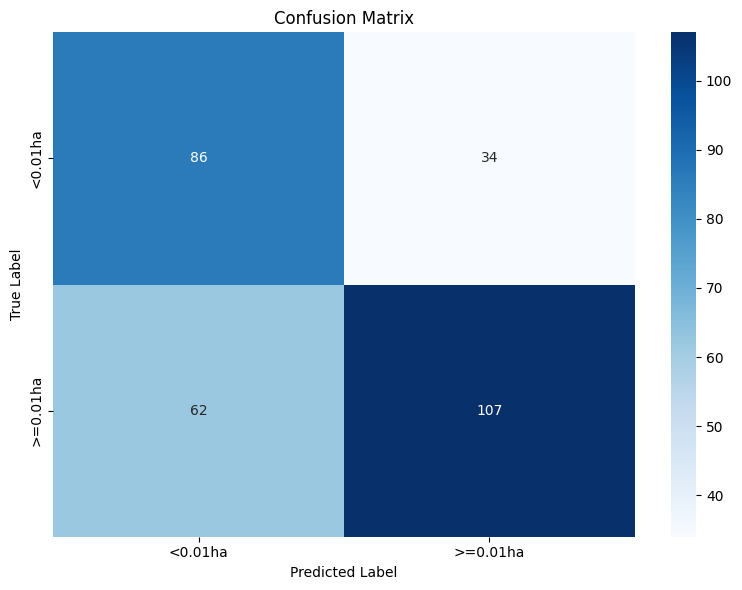

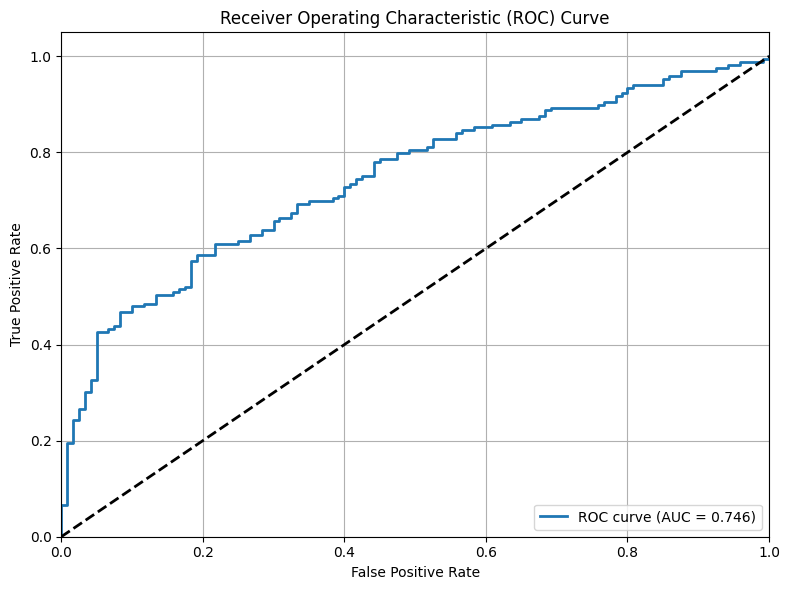

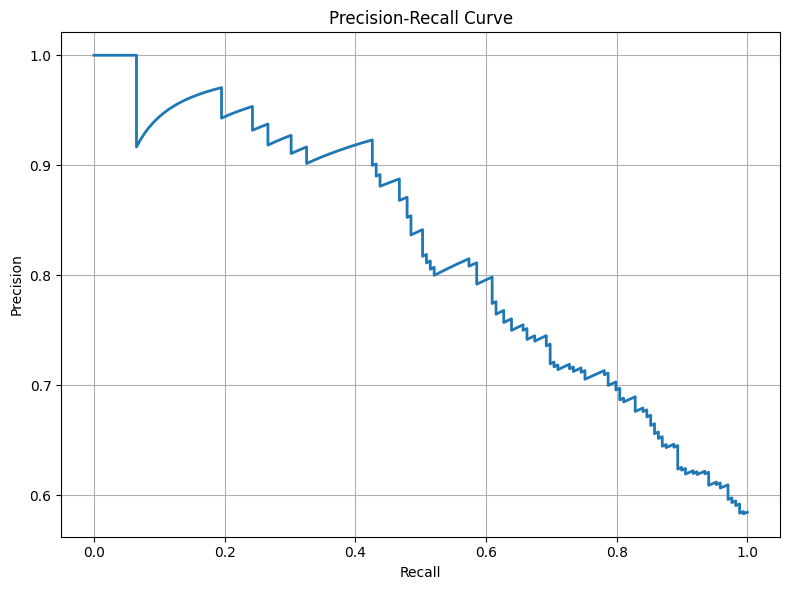

In [25]:
# 9. VISUALIZE MODEL PERFORMANCE
print("\n9. VISUALIZING MODEL PERFORMANCE")
print("-"*50)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'<{threshold}ha', f'>={threshold}ha'],
            yticklabels=[f'<{threshold}ha', f'>={threshold}ha'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))

# Plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'roc_curve.png'))

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_proba)
plt.plot(recall, precision, lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'precision_recall_curve.png'))



10. FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------
Feature importance saved to /Users/rchang/ML-Projects/wildfire-prediction-can/models/tabnet/classification_2/feature_importance.csv
Top 5 features by TabNet importance:
  1. snwfl_amt_pst1hr: 0.0614
  2. snw_dpth: 0.0484
  3. MAX_TEMP: 0.0415
  4. temperature: 0.0413
  5. avg_wnd_dir_10m_pst10mts: 0.0407


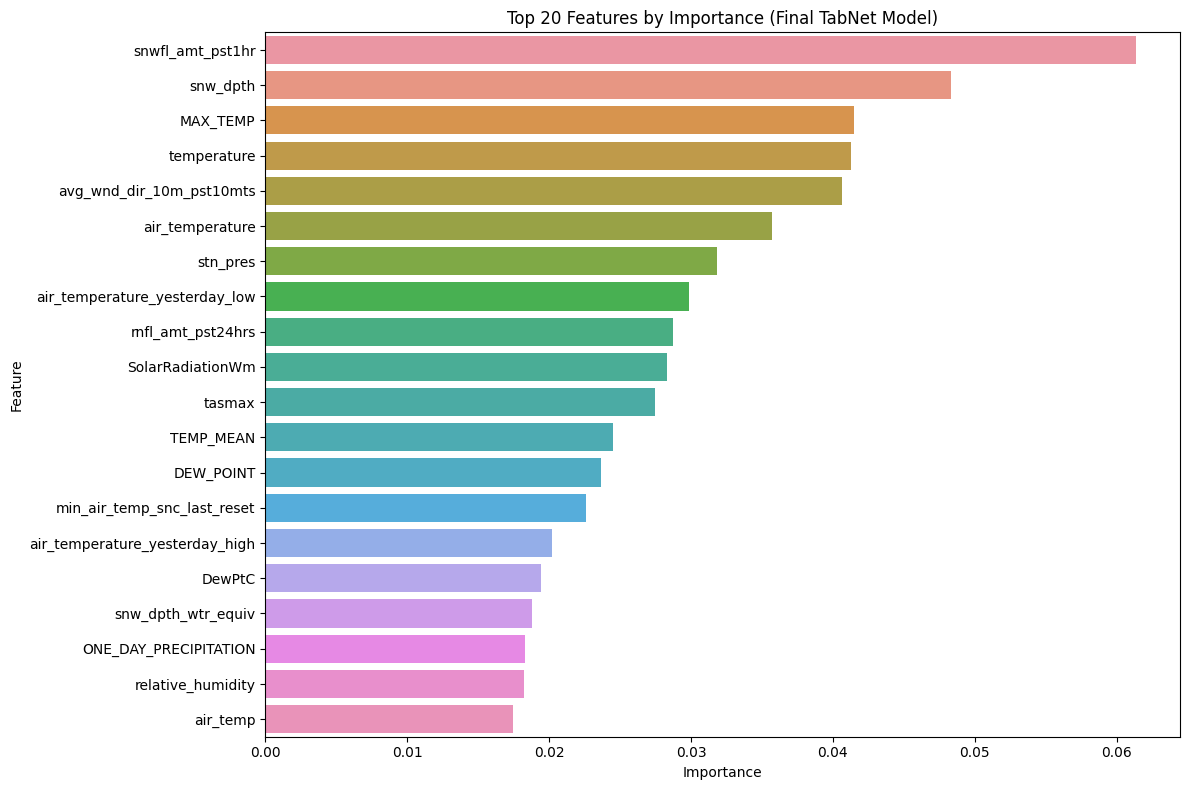

In [26]:
# 10. FEATURE IMPORTANCE ANALYSIS
print("\n10. FEATURE IMPORTANCE ANALYSIS")
print("-"*50)

# TabNet provides feature importance via a mask that quantifies feature usage
final_feature_importance = final_model.feature_importances_

# Create DataFrame for feature importance
final_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': final_feature_importance
}).sort_values('Importance', ascending=False)

# Save feature importance to CSV
final_importance_df.to_csv(os.path.join(output_dir, 'feature_importance.csv'), index=False)
print(f"Feature importance saved to {os.path.join(output_dir, 'feature_importance.csv')}")

# Plot feature importance (top 20)
plt.figure(figsize=(12, 8))
top_features = final_importance_df.head(20)
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 20 Features by Importance (Final TabNet Model)')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'feature_importance.png'))

print("Top 5 features by TabNet importance:")
for i, (_, row) in enumerate(final_importance_df.head(5).iterrows()):
    print(f"  {i+1}. {row['Feature']}: {row['Importance']:.4f}")


In [28]:
# 11. CONCLUSION AND SUMMARY
print("\n11. MODEL TRAINING SUMMARY")
print("-"*50)

# Store results
results.update({
    'model': final_model,
    'scaler': scaler,
    'best_params': best_params,
    'batch_size': batch_size,
    'feature_cols': feature_cols,
    'metrics': metrics,
    'threshold': threshold
})

# Create summary report
with open(os.path.join(output_dir, 'model_training_summary.txt'), 'w') as f:
    f.write("WILDFIRE CLASSIFICATION TABNET MODEL TRAINING SUMMARY\n")
    f.write("="*50 + "\n\n")
    
    f.write(f"Classification Task: Predict if fire size is >= {threshold} hectares\n\n")
    
    f.write("1. Dataset Information:\n")
    f.write(f"   - Total samples: {len(df)}\n")
    f.write(f"   - Class 0 (< {threshold} ha): {class_counts[0]} samples ({class_percentages[0]:.2f}%)\n")
    f.write(f"   - Class 1 (>= {threshold} ha): {class_counts[1]} samples ({class_percentages[1]:.2f}%)\n")
    f.write(f"   - Initial features: {len(feature_cols)}\n\n")
    
    f.write("2. Model Performance:\n")
    f.write(f"   - Test Accuracy: {test_accuracy:.4f}\n")
    f.write(f"   - Test Precision: {test_precision:.4f}\n")
    f.write(f"   - Test Recall: {test_recall:.4f}\n")
    f.write(f"   - Test F1 Score: {test_f1:.4f}\n")
    f.write(f"   - Test AUC: {test_auc:.4f}\n\n")
    
    f.write("3. Top 5 Most Important Features:\n")
    for i, (_, row) in enumerate(final_importance_df.head(5).iterrows()):
        f.write(f"   {i+1}. {row['Feature']}: {row['Importance']:.4f}\n")
    f.write("\n")
    
    f.write("4. Model Configuration:\n")
    for param, value in best_params.items():
        f.write(f"   - {param}: {value}\n")
    f.write(f"   - batch_size: {batch_size}\n")
    
    if class_weights is not None:
        f.write("\n5. Class Weights Used:\n")
        for i, weight in enumerate(class_weights):
            f.write(f"   - Class {i}: {weight:.4f}\n")

print(f"Model training summary saved to {os.path.join(output_dir, 'model_training_summary.txt')}")
print("\nModel training complete! All outputs saved to", output_dir)


11. MODEL TRAINING SUMMARY
--------------------------------------------------
Model training summary saved to /Users/rchang/ML-Projects/wildfire-prediction-can/models/tabnet/classification_2/model_training_summary.txt

Model training complete! All outputs saved to /Users/rchang/ML-Projects/wildfire-prediction-can/models/tabnet/classification_2
